In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
%matplotlib inline

In [3]:
words = open("names.txt").read().splitlines()

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s : i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}

In [5]:
block_size = 3

def build_dataset(words, block_size=3):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [23]:
g = torch.Generator().manual_seed(2147483647)

emb_size = 10
layer1 = 200

""" 
The multiplication by 0.1 or 0.01 is done to solve 2 problems:
1) at initialization the network should have uniform probability for prediction. This means that the entropy is also max.
2) the hidden layers output activations too large and so the tanh is saturated (derivative will be 0). 
    We solve this by scaling the output around 0.
"""

tanh_gain = 5/3.0

# embedding 
C = torch.randn((27, emb_size), generator=g)
W1 = torch.randn((block_size * emb_size, layer1), generator=g) * tanh_gain / (emb_size * block_size) ** 0.5 # kaiming init 
b1 = torch.randn(layer1, generator=g) * 0.01
W2 = torch.randn((layer1, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [7]:
sum(p.nelement() for p in parameters) # num of parameters

11897

In [24]:
max_steps = 200_000
batch_size = 32
lossi = [] 
stepi = []
# lr = 0.01
for i in range(max_steps):
    # take a minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass 
    emb = C[Xb]
    h_pre = emb.view(-1, block_size * emb_size) @ W1  + b1
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update 
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3095


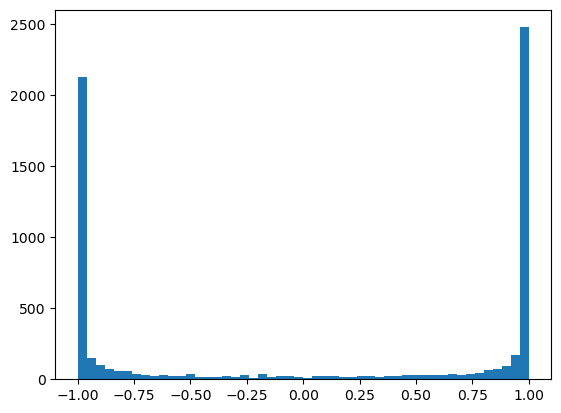

In [21]:
# before scaling of hidden layer
plt.hist(h.view(-1).tolist(), 50);

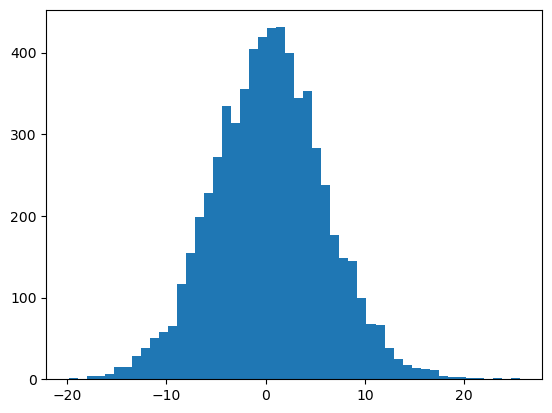

In [17]:
plt.hist(h_pre.view(-1).tolist(), 50);

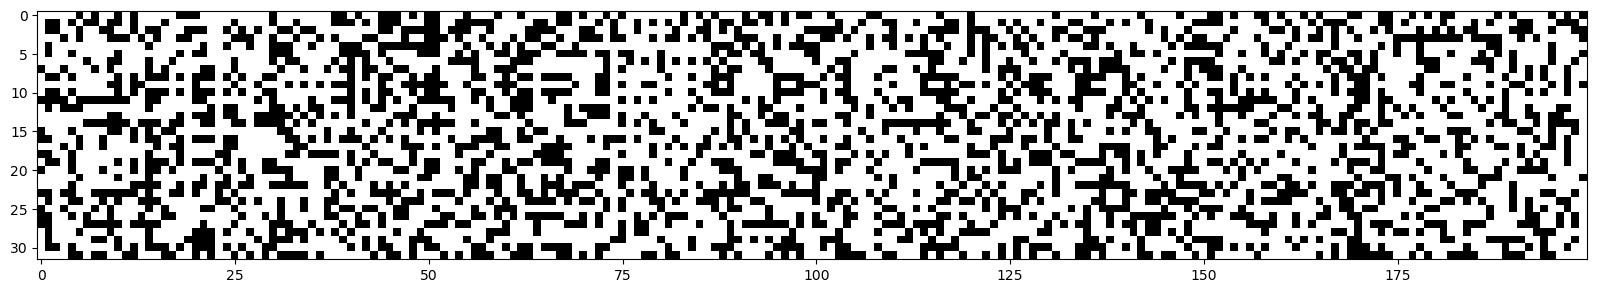

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

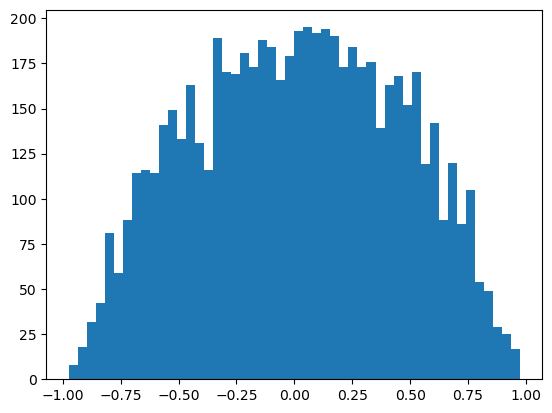

In [25]:
# after mult by 0.1 of hidden layer 
plt.hist(h.view(-1).tolist(), 50);

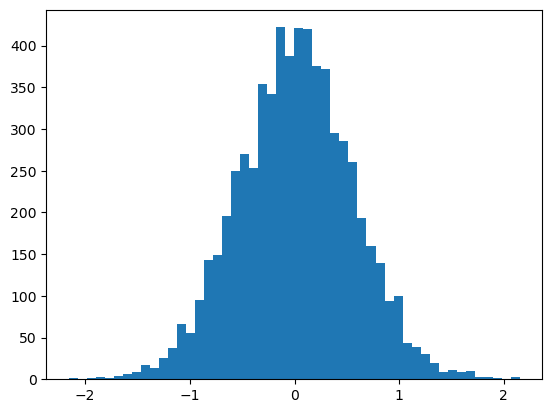

In [26]:
plt.hist(h_pre.view(-1).tolist(), 50);

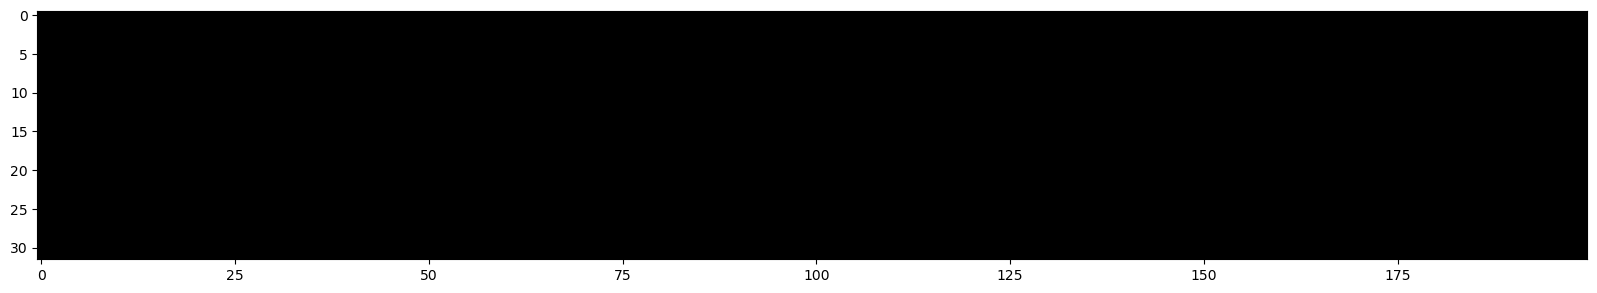

In [27]:
# As we can see there are no saturated neurons.
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

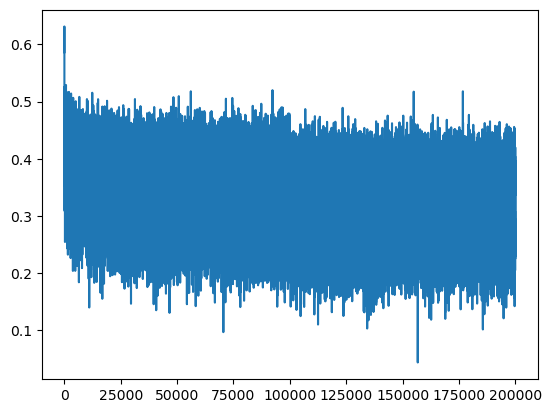

In [11]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xval, Yval),
        "test": (Xtest, Ytest)
    }[split]

    emb = C[Xb]
    h_pre = emb.view(-1, block_size * emb_size) @ W1  + b1
    h = torch.tanh(h_pre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    print(split, loss.item())

split_loss("train")
split_loss("val")